# Water fitting workflow
- This workflow assumes that you haven't done any processing on the Raman computer,
e.g. feed in raw H$_2$O and olivine spectra
- First it finds the best possible unmix to reduce the peak-trough distance of the olivine peaks in the mixed spectra
- Then it fits a background to two positions (can choose, but approximatly that of DiDenova et al. 2017), 
- Then it calculates the area under these background curves between the baselines, using a trapezoid or simpson rule

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import scipy
from scipy import stats

## Specify your path here, and files for olivine and MI

In [323]:
path=r'G:\My Drive\Postdoc\MeltInclusion_SampleStuff\Raman\Day18\Spectra'


In [324]:
H2O_files=pf.get_Ne_files(path, ID_str='H2O',
                           file_ext='.txt', exclude_str='scan', sort=True)
Ol_files=pf.get_Ne_files(path, ID_str='Ol',
                           file_ext='.txt', exclude_str='scan', sort=True)

In [325]:
print('H2O_files')
print(H2O_files)
print('Ol_files')
print(Ol_files)

H2O_files
['02 BL1_MI1_H2O_Quant.txt', '05 BL8_MI1_5umd_H2O_Quant.txt', '06 BL8_MI1_10umd_H2O_Quant.txt', '07 BL8_MI1_p5umd_H2O_Quant.txt', '09 CC1_MI2_m11um_H2OQuant_20X.txt', '10 CC1_MI2_m13_H2OQuant_50X.txt', '11 CC1_MI2_m20_H2OQuant_50X.txt', '14 CC2_MI2_H2OQuant_m5.txt', '15 CC2_MI2_H2OQuant_m15.txt', '16 CC2_MI2_H2OQuant_p3.txt', '18 CC4_MI1_H2OQuant.txt', '22 CC7_MI3_p8_H2OQuant.txt', '23 CC7_MI3_m8_H2OQuant.txt', '26 MS14_11_H2OQuant.txt', '28 MS14_7_H2O_20xbutsaid50X.txt', '30 MS14_7_H2O_50X.txt', '32 MS14_8_H2OQuant.txt', '35 MW9_H2O.txt']
Ol_files
['03 BL1_MI1_Ol.txt', '08 BL8_MI1_Ol.txt', '12 CC1_MI2_OlQuant.txt', '19 CC4_MI1_OlQuant.txt', '20 CC2_MI2_Ol.txt', '24 CC7_MI3_Ol.txt', '29 MS14_7_Ol.txt', '33 MS14_8_Ol.txt', '36 MW9_Ol.txt']


In [326]:
MI_file='18 CC4_MI1_H2OQuant.txt'
Ol_file='19 CC4_MI1_OlQuant.txt'
filetype='Witec_ASCII'

## Load in melt inclusion and olivine data

In [327]:
MI=pf.get_data(path=path, filename=MI_file,
                  filetype=filetype)
Ol=pf.get_data(path=path, filename=Ol_file,
                  filetype=filetype)

18 CC4_MI1_H2OQuant.txt
19 CC4_MI1_OlQuant.txt


## Functions for smoothing and finding olivine peaks and troughs. 

peak_pos_Ol_unsort
[827.84795503 859.61874585]
[957.59557904 957.5826929  957.56980493 ... 883.57817869 883.58585466
 883.59352948]


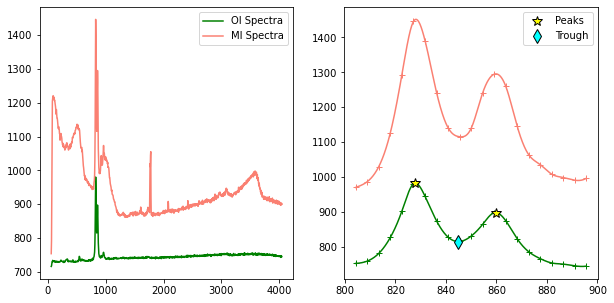

In [328]:
x_new, y_cub_MI, y_cub_Ol, peak_pos_Ol, peak_height_Ol, trough_x, trough_y=smooth_and_trim_around_olivine(x_min=800, x_max=900,
            Ol_spectra=Ol, MI_spectra=MI)

## Subtracting out the olivine spectra
- Logic is find 2 strong olivine peaks. Also find trough. As you progressively subtract out olivine, eventually the peaks invert, and the trough becomes a peak once you have subtracted out too much olivine. We are looking for the point at which the trough position is higher than a linear regression between the two peak positions

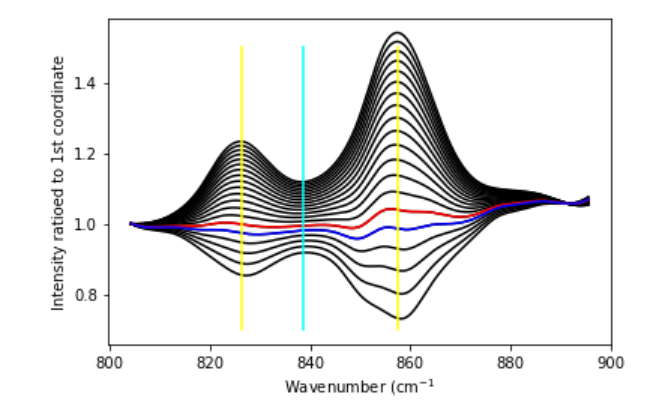

In [329]:
## Lets write a function that fits a line through the peaks, 
# and sees if the trough is above or below
#Filt_MI
def trough_or_peak_higher(spectra_x, spectra_y, peak_pos_x, 
                          trough_pos_x, av_width=1, plot=False,
                         printfig=False):

    peak1_xex=peak_pos_x[0]
    peak2_xex=peak_pos_x[1]

    
    # Takes average av_width to either side of peak
    peak1_y=spectra_y[(spectra_x>peak1_xex-av_width)
                     &(spectra_x<peak1_xex+av_width)]
    peak2_y=spectra_y[(spectra_x>peak2_xex-av_width)
                     &(spectra_x<peak2_xex+av_width)]
    
    peak1_x=spectra_x[(spectra_x>peak1_xex-av_width)
                     &(spectra_x<peak1_xex+av_width)]
    peak2_x=spectra_x[(spectra_x>peak2_xex-av_width)
                     &(spectra_x<peak2_xex+av_width)]
    
    
    trough_y=spectra_y[(spectra_x>trough_pos_x-av_width)
                     &(spectra_x<trough_pos_x+av_width)]
    
    trough_x=spectra_x[(spectra_x>trough_pos_x-av_width)
                     &(spectra_x<trough_pos_x+av_width)]
    
    

    x=np.concatenate((peak1_x, peak2_x), axis=0)
    
    y=np.concatenate((peak1_y, peak2_y), axis=0)

    
    Px = np.linspace(peak1_x, peak2_x, 101)



    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    Py=slope*Px+intercept
    Pred_trough=slope*np.nanmean(trough_x)+intercept
    
    if printfig is True:
        if np.nanmean(trough_y)>np.nanmean(Pred_trough):
            print('Trough higher than peaks, subtracted too much')

        if np.nanmean(trough_y)<np.nanmean(Pred_trough):
            print('Trough lower than peaks, not subtracted enough')
    Dist=np.nanmean(trough_y)-np.nanmean(Pred_trough)
    #Py=lr.predict(Px)
    if plot is True:
        plt.plot(peak1_x, peak1_y, '+m')
        plt.plot(peak2_x, peak2_y, '+m')
        plt.plot(trough_x, trough_y, '+g')

        plt.plot(Px, Py, '-r')
        plt.plot(trough_pos_x, Pred_trough, '*k', ms=10)
        plt.plot(spectra_x, spectra_y, '-k')
    return Dist
    

# Now make mixed spectra
- For N steps, goes from X=0 % to X=100% olivine, and does an unmixing using the equation:
    
Mixed spectra (measured) = (Pure Olivine Spectra * X olivine) +
(Pure Glass Spectra * (1 - X Olivine))

In [330]:
# Now lets mix up spectra
def make_evaluate_mixed_spectra(smoothed_Ol_y, smoothed_MI_y,
                                Ol_spectra, MI_spectra, x_new, peak_pos_Ol,
                      trough_x, N_steps=20, av_width=2,
                               X_min=0, X_max=1):
    N_steps=20
    MI_Mix=np.empty((N_steps,len(smoothed_MI_y)), 'float')
    Dist=np.empty(N_steps, 'float')
    X=np.linspace(X_min, X_max, N_steps)
    for i in range(0, N_steps):

        
        print(X[i])

        # Geochemistry style mix 
        #MI_Mix[i, :]=(smoothed_MI_y- smoothed_Ol_y*X[i])/(1-X[i])
        # True subtraction mix from Smith 2021
        MI_Mix[i, :]=smoothed_MI_y- smoothed_Ol_y*X[i]
        
        Dist[i]=trough_or_peak_higher(spectra_x=x_new,
                          spectra_y=MI_Mix[i, :],
                          peak_pos_x=peak_pos_Ol,
                          trough_pos_x=trough_x, av_width=2)
        #print(MI_Mix)
        
    mix_spline = interp1d(X, Dist, kind='cubic')

    x_new_mix=np.linspace(min(X), max(X), 5000)

    y_cub_mix=mix_spline(x_new_mix)
    
    
    # Closest point to zero
    val=np.argmax(y_cub_mix>0)
    ideal_mix=x_new_mix[val]
    print('best fit proportion')
    print(ideal_mix)

    MI_Mix_Best_syn=(smoothed_MI_y-smoothed_Ol_y*ideal_mix)/(1-ideal_mix)
    MI_Mix_Best=(MI_spectra- Ol_spectra*ideal_mix)/(1-ideal_mix)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10))

    for i in range(0, N_steps):
        ax1.plot(x_new, MI_Mix[i, :], '-k')
        ax1.plot([peak_pos_Ol[0], peak_pos_Ol[0]], [0.7, 1.5], '-', color='yellow')
        ax1.plot([peak_pos_Ol[1], peak_pos_Ol[1]], [0.7, 1.5], '-', color='yellow')
        ax1.plot([trough_x, trough_x], [0.7, 1.5], '-', color='cyan')


    ax1.set_xlabel('Wavenumber (cm$^{-1}$')
    ax1.set_ylabel('Intensity ratioed to 1st coordinate')

    ax2.plot(X, Dist, 'or')
    ax2.plot([min(X), max(X)], [0, 0], '-k')
    ax2.set_xlabel('Mixing Proportion of Olivine')
    ax2.set_ylabel('Vert. Dist. between peaks reg & troughs')
    ax2.plot(x_new_mix, y_cub_mix, '-r')
    
    ax3.plot(MI[:, 0],MI_Mix_Best[:, 1], '-k')
    ax3.plot(MI[:, 0],MI[:, 1], '-', color='salmon')
    ax3.plot(Ol[:, 0],Ol[:, 1], '-', color='g')
    ax3.set_xlim([775, 900])


    ax4.plot(MI[:, 0],MI_Mix_Best[:, 1], '-k', label='Umixed glass')
    ax4.plot(MI[:, 0],MI[:, 1],  '-', color='salmon',label='Measured MI')
    ax4.plot(Ol[:, 0],Ol[:, 1], '-', color='g', label='Measured Ol')
    ax4.legend()
    ax3.set_xlabel('Wavenumber (cm$^{-1}$')
    ax4.set_xlabel('Wavenumber (cm$^{-1}$')
    ax3.set_ylabel('Intensity')



    return MI_Mix_Best, ideal_mix, Dist, MI_Mix, X

0.0
0.5263157894736842
1.0526315789473684
1.5789473684210527
2.1052631578947367
2.631578947368421
3.1578947368421053
3.6842105263157894
4.2105263157894735
4.7368421052631575
5.263157894736842
5.789473684210526
6.315789473684211
6.842105263157895
7.368421052631579
7.894736842105263
8.421052631578947
8.947368421052632
9.473684210526315
10.0
best fit proportion
2.0864172834566914


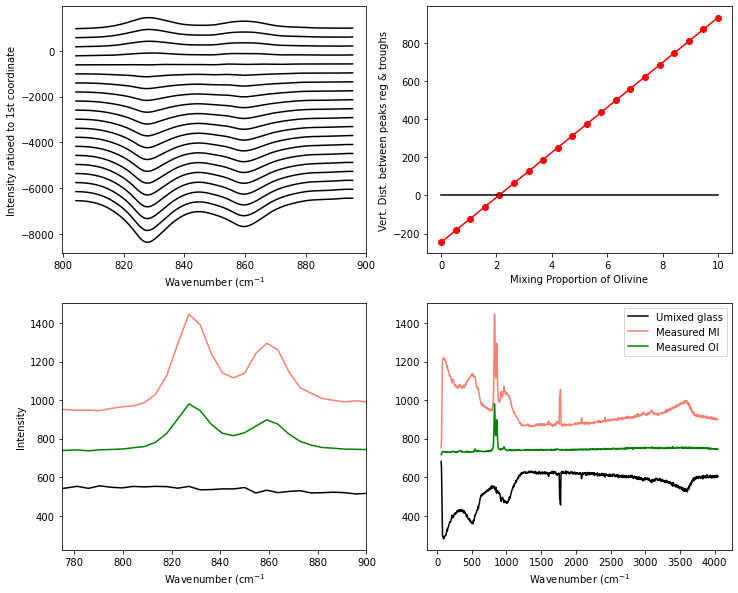

In [331]:
MI_Mix_Best, ideal_mix, Dist, MI_Mix, X=make_evaluate_mixed_spectra(
Ol_spectra=Ol, MI_spectra=MI,smoothed_Ol_y=y_cub_Ol, 
smoothed_MI_y=y_cub_MI, 
x_new=x_new, peak_pos_Ol=peak_pos_Ol, trough_x=trough_x,
X_min=0, X_max=10, av_width=2)


## Silica region Area calc

In [332]:
def fit_area_for_silicate_region(Spectra=None, lower_range_sil=[200, 300], upper_range_sil=[1240, 1500],
sigma_sil=5, exclude_range1_sil=None, exclude_range2_sil=None, N_poly_sil=2, plot_figure=True,
fit_sil='poly'):
    
    Sil=Spectra
    exclude=False
    # These bits of code trim out the excluded regions if relevant
    if exclude_range1_sil is not None and exclude_range2_sil is None:
        exclude=True
        Sil_old=Sil.copy()
        Sil=Sil[(Sil[:, 0]<exclude_range1_sil[0])|(Sil[:, 0]>exclude_range1_sil[1])]
        Discard=Sil_old[(Sil_old[:, 0]>=exclude_range1_sil[0])
                        & (Sil_old[:, 0]<=exclude_range1_sil[1])]


    if exclude_range2_sil is not None and exclude_range1_sil is None:
        exclude=True
        Sil_old=Sil.copy()
        Sil=Sil[(Sil[:, 0]<exclude_range2_sil[0])|(Sil[:, 0]>exclude_range2_sil[1])]

        Discard=Sil_old[(Sil_old[:, 0]>=exclude_range2_sil[0]) 
                        & (Sil_old[:, 0]<=exclude_range2_sil[1])]

    if exclude_range1_sil is not None and exclude_range2_sil is not None:
        exclude=True
        Sil_old=Sil.copy()
        Sil=Sil[
        ((Sil[:, 0]<exclude_range1_sil[0])|(Sil[:, 0]>exclude_range1_sil[1]))
        &
        ((Sil[:, 0]<exclude_range2_sil[0])|(Sil[:, 0]>exclude_range2_sil[1]))
        ]

        Discard=Sil_old[
        ((Sil_old[:, 0]>=exclude_range1_sil[0]) & (Sil_old[:, 0]<=exclude_range1_sil[1]))
        |
        ((Sil_old[:, 0]>=exclude_range2_sil[0]) & (Sil_old[:, 0]<=exclude_range2_sil[1]))
        ]
    

    # Now we calculate the edge of the baseline
    lower_0baseline_sil=lower_range_sil[0]
    upper_0baseline_sil=lower_range_sil[1]
    lower_1baseline_sil=upper_range_sil[0]
    upper_1baseline_sil=upper_range_sil[1]

    # Bit that is actually peak, not baseline
    span=[upper_0baseline_sil, lower_1baseline_sil]

    # lower_2baseline=1320
    # upper_2baseline=1330

    # Trim for entire range
    Sil_short=Sil[ (Sil[:,0]>lower_0baseline_sil) 
                  & (Sil[:,0]<upper_1baseline_sil) ]

    # Get actual baseline
    Baseline_with_outl_sil=Sil_short[
    ((Sil_short[:, 0]<upper_0baseline_sil) &(Sil_short[:, 0]>lower_0baseline_sil))
         |
    ((Sil_short[:, 0]<upper_1baseline_sil) &(Sil_short[:, 0]>lower_1baseline_sil))]

    # Calculates the median for the baseline and the standard deviation
    Median_Baseline_sil=np.mean(Baseline_with_outl_sil[:, 1])
    Std_Baseline_sil=np.std(Baseline_with_outl_sil[:, 1])

    # Removes any points in the baseline outside of 2 sigma (helps remove cosmic rays etc).
    Baseline_sil=Baseline_with_outl_sil[
    (Baseline_with_outl_sil[:, 1]<Median_Baseline_sil+sigma_sil*Std_Baseline_sil)
                                &
    (Baseline_with_outl_sil[:, 1]>Median_Baseline_sil-sigma_sil*Std_Baseline_sil)
                               ]


    #Baseline=Baseline_with_outl


    if fit_sil == 'poly':
        # Fits a polynomial to the baseline of degree
        Pf_baseline_sil = np.poly1d(np.polyfit(Baseline_sil[:, 0], Baseline_sil[:, 1], N_poly_sil))
        Py_base_sil =Pf_baseline_sil(Sil_short[:, 0])



        Baseline_ysub_sil=Pf_baseline_sil(Sil_short[:, 0])


    if  fit_sil == 'spline':
        from scipy.interpolate import CubicSpline
        mix_spline_sil = CubicSpline(Baseline_sil[:, 0], Baseline_sil[:, 1],  
                                extrapolate=True)

        Baseline_ysub_sil=mix_spline_sil(Sil_short[:, 0]) 


        N_poly_sil='Spline'

    Baseline_x_sil=Sil_short[:, 0]
    y_corr_sil= Sil_short[:, 1]- Baseline_ysub_sil

    x_sil=Baseline_sil[:, 0]

     # Plotting what its doing
    if plot_figure is True:

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
        
        if  exclude is True:
            ax1.plot(Discard[:, 0], Discard[:, 1], '*k', label='Discarded points')
            ax1.legend()
        ax1.set_title('Background fit')
        ax1.plot(Sil_short[:, 0], Sil_short[:, 1], '-r')

        ax1.plot(Baseline_sil[:, 0], Baseline_sil[:, 1], '.b')
        ax1.plot(Sil_short[:, 0], Baseline_ysub_sil, '-k')
        xdat_sil=(Sil_short[:, 0])
        ydat_sil=y_corr_sil

        ax1.set_ylabel('Intensity')
        ax2.set_ylabel('Intensity')
        ax2.set_xlabel('Wavenumber')



        ax2.set_title('Background corrected')
        ax2.plot(xdat_sil, y_corr_sil, '-r')
        height_p=np.max(Sil_short[:, 1])-np.min(Sil_short[:, 1])
        #ax2.set_ylim([np.min(y_corr), 1.2*height_p ])
        ax1.set_xlabel('Wavenumber')


    from numpy import trapz
    from scipy.integrate import simps
    xspace_sil=xdat_sil[1]-xdat_sil[0]
    area_trap = trapz(y_corr_sil, dx=xspace_sil)
    area_simps = simps(y_corr_sil, dx=xspace_sil)



    df_sil=pd.DataFrame(data={'Sil_LHS_Back1':lower_range_sil[0],
                          'Sil_LHS_Back2':lower_range_sil[1],
                          'Sil_RHS_Back1':upper_range_sil[0],
                          'Sil_RHS_Back2':upper_range_sil[1],
                          'Sil_N_Poly': N_poly_sil,
                          'Sil_Trapezoid_Area':area_trap,
                          'Sil_Simpson_Area': area_simps}, index=[0])
    return df_sil    
                                 

In [333]:
def check_if_spectra_negative(Spectra=None, override=False, flip=False):
    Spectra=Spectra.copy()
    
    mean_around_peak=np.nanmean(
        MI_Mix_Best[(MI_Mix_Best[:, 0]>peak_pos_Ol[0])
        &
        (MI_Mix_Best[:, 0]<peak_pos_Ol[0]+5)]
            )
    print('end')
    print(MI_Mix_Best[8, 1])
    print('mean around peak')
    print(mean_around_peak)
    if override is False:
        if mean_around_peak<MI_Mix_Best[8, 1]:


            print('peak positive, spectra left as is')
            return Spectra
        else:
            print('Peak negative, spectra inverted')
            x=Spectra[:, 0]
            y=-Spectra[:, 1]
            plt.plot(x, y, '-r')
            Spectra2=np.column_stack((x, y))
            return Spectra2
        
    if override is True:
        print('Youve choosen to override the default')
        
        if flip is False:
            return Spectra
        if flip is True:
            print('spectra inverted')
            x=Spectra[:, 0]
            y=-Spectra[:, 1]
            plt.plot(x, y, '-r')
            Spectra2=np.column_stack((x, y))            
            
            return Spectra2


end
289.1444719657522
mean around peak
682.9947005535629
Peak negative, spectra inverted


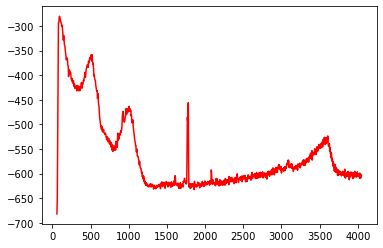

In [334]:
Spectra=check_if_spectra_negative(Spectra=MI_Mix_Best, override=False, flip=False)

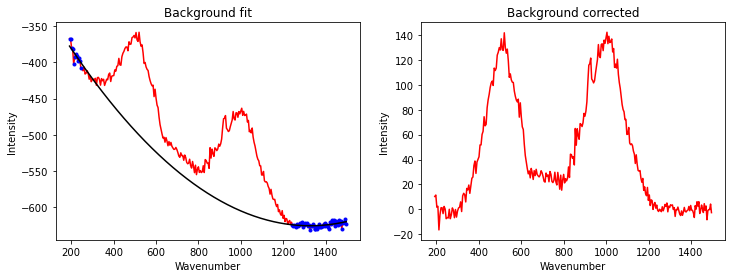

In [335]:
df_sil=fit_area_for_silicate_region(Spectra=Spectra, lower_range_sil=[190, 250], upper_range_sil=[1240, 1500],
sigma_sil=5, exclude_range1_sil=None, exclude_range2_sil=None, N_poly_sil=2, plot_figure=True,
fit_sil='poly')

## Same for H2O curve

In [336]:
def fit_area_for_water_region(Spectra=None, lower_range_water=[2750, 3100], upper_range_water=[3750, 4100],
sigma_water=5, exclude_range1_water=None, exclude_range2_water=None,
N_poly_water=2, plot_figure=True, fit_water='poly'):
    
    Water=Spectra
    exclude=False




    # These bits of code trim out the excluded regions if relevant
    if exclude_range1_water is not None and exclude_range2_water is None:
        exclude=True
        Water_old=Water.copy()
        Water=Water[(Water[:, 0]<exclude_range1_water[0])|(Water[:, 0]>exclude_range1_water[1])]
        Discard=Water_old[(Water_old[:, 0]>=exclude_range1_water[0])
                        & (Water_old[:, 0]<=exclude_range1_water[1])]


    if exclude_range2_water is not None and exclude_range1_water is None:
        exclude=True
        Water_old=Water.copy()
        Water=Water[(Water[:, 0]<exclude_range2_water[0])|(Water[:, 0]>exclude_range2_water[1])]

        Discard=Water_old[(Water_old[:, 0]>=exclude_range2_water[0]) 
                        & (Water_old[:, 0]<=exclude_range2_water[1])]

    if exclude_range1_water is not None and exclude_range2_water is not None:
        exclude=True
        Water_old=Water.copy()
        Water=Water[
        ((Water[:, 0]<exclude_range1_water[0])|(Water[:, 0]>exclude_range1_water[1]))
        &
        ((Water[:, 0]<exclude_range2_water[0])|(Water[:, 0]>exclude_range2_water[1]))
        ]

        Discard=Water_old[
        ((Water_old[:, 0]>=exclude_range1_water[0]) & (Water_old[:, 0]<=exclude_range1_water[1]))
        |
        ((Water_old[:, 0]>=exclude_range2_water[0]) & (Water_old[:, 0]<=exclude_range2_water[1]))
        ]


    # Now we calculate the edge of the baseline
    lower_0baseline_water=lower_range_water[0]
    upper_0baseline_water=lower_range_water[1]
    lower_1baseline_water=upper_range_water[0]
    upper_1baseline_water=upper_range_water[1]

    # Bit that is actually peak, not baseline
    span=[upper_0baseline_water, lower_1baseline_water]

    # lower_2baseline=1320
    # upper_2baseline=1330

    # Trim for entire range
    Water_short=Water[ (Water[:,0]>lower_0baseline_water) 
                  & (Water[:,0]<upper_1baseline_water) ]

    # Get actual baseline
    Baseline_with_outl_water=Water_short[
    ((Water_short[:, 0]<upper_0baseline_water) &(Water_short[:, 0]>lower_0baseline_water))
         |
    ((Water_short[:, 0]<upper_1baseline_water) &(Water_short[:, 0]>lower_1baseline_water))]

    # Calculates the median for the baseline and the standard deviation
    Median_Baseline_water=np.mean(Baseline_with_outl_water[:, 1])
    Std_Baseline_water=np.std(Baseline_with_outl_water[:, 1])

    # Removes any points in the baseline outside of 2 sigma (helps remove cosmic rays etc).
    Baseline_water=Baseline_with_outl_water[
    (Baseline_with_outl_water[:, 1]<Median_Baseline_water+sigma_water*Std_Baseline_water)
                                &
    (Baseline_with_outl_water[:, 1]>Median_Baseline_water-sigma_water*Std_Baseline_water)
                               ]


    #Baseline=Baseline_with_outl


    if fit_water == 'poly':
        # Fits a polynomial to the baseline of degree
        Pf_baseline_water = np.poly1d(np.polyfit(Baseline_water[:, 0], Baseline_water[:, 1], N_poly_water))
        Py_base_water =Pf_baseline_water(Water_short[:, 0])



        Baseline_ysub_water=Pf_baseline_water(Water_short[:, 0])


    if  fit_water == 'spline':
        from scipy.interpolate import CubicSpline
        mix_spline_water = CubicSpline(Baseline_water[:, 0], Baseline_water[:, 1],  
                                extrapolate=True)

        Baseline_ysub_water=mix_spline_water(Water_short[:, 0]) 


        N_poly_water='Spline'

    Baseline_x_water=Water_short[:, 0]
    y_corr_water= Water_short[:, 1]- Baseline_ysub_water

    x_water=Baseline_water[:, 0]

     # Plotting what its doing
    if plot_figure is True:

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
        ax1.set_title('Background fit')
        ax1.plot(Water_short[:, 0], Water_short[:, 1], '-r')
        if  exclude is True:
            ax1.plot(Discard[:, 0], Discard[:, 1], '*k', label='Discarded points')
            ax1.legend()

        ax1.plot(Baseline_water[:, 0], Baseline_water[:, 1], '.b')
        ax1.plot(Water_short[:, 0], Baseline_ysub_water, '-k')
        xdat_water=(Water_short[:, 0])
        ydat_water=y_corr_water

        ax1.set_ylabel('Intensity')
        ax2.set_ylabel('Intensity')
        ax2.set_xlabel('Wavenumber')



        ax2.set_title('Background corrected')
        ax2.plot(xdat_water, y_corr_water, '-r')
        height_p=np.max(Water_short[:, 1])-np.min(Water_short[:, 1])
        
        ax1.set_xlabel('Wavenumber')


    from numpy import trapz
    from scipy.integrate import simps
    xspace_water=xdat_water[1]-xdat_water[0]
    area_trap = trapz(y_corr_water, dx=xspace_water)
    area_simps = simps(y_corr_water, dx=xspace_water)



    df_water=pd.DataFrame(data={'Water_LHS_Back1':lower_range_water[0],
                          'Water_LHS_Back2':lower_range_water[1],
                          'Water_RHS_Back1':upper_range_water[0],
                          'Water_RHS_Back2':upper_range_water[1],
                          'Water_N_Poly': N_poly_water,
                          'Water_Trapezoid_Area':area_trap,
                          'Water_Simpson_Area': area_simps}, index=[0])
    return df_water

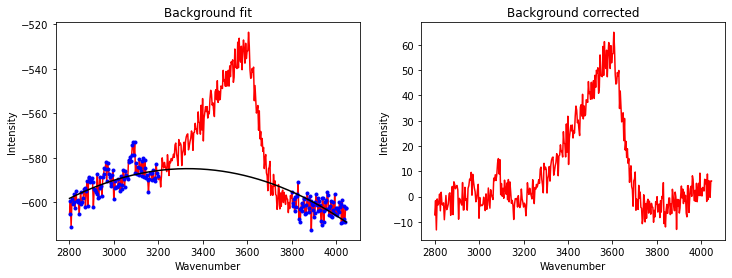

In [340]:
df_water=fit_area_for_water_region(Spectra=Spectra, lower_range_water=[2800, 3200], 
upper_range_water=[3800, 4100],
sigma_water=5, exclude_range1_water=None, exclude_range2_water=None,
N_poly_water=2, plot_figure=True, fit_water='poly')

## Stitch these dataframes together 

In [341]:
def stitch_dataframes_together(df_sil=None, df_water=None, Ol_file=None, MI_file=None):
    Combo_Area=pd.concat([df_sil, df_water], axis=1)
    Combo_Area.insert(0, 'Olivine filename', Ol_file)
    Combo_Area.insert(1, 'MI filename', MI_file)
    Combo_Area.insert(2, 'Trap_H2O_Sil', 
                      Combo_Area['Water_Trapezoid_Area']/Combo_Area['Sil_Trapezoid_Area'])
    Combo_Area.insert(3, 'Simp_H2O_Sil',
                      Combo_Area['Water_Simpson_Area']/Combo_Area['Sil_Simpson_Area'])

    return Combo_Area
                               
df_stitch=stitch_dataframes_together(df_sil=df_sil, df_water=df_water, Ol_file=Ol_file, MI_file=MI_file)  
df_stitch.to_clipboard(excel=True, header=False, index=None)

In [342]:
df_stitch

,Olivine filename,MI filename,Trap_H2O_Sil,Simp_H2O_Sil,Sil_LHS_Back1,Sil_LHS_Back2,Sil_RHS_Back1,Sil_RHS_Back2,Sil_N_Poly,Sil_Trapezoid_Area,Sil_Simpson_Area,Water_LHS_Back1,Water_LHS_Back2,Water_RHS_Back1,Water_RHS_Back2,Water_N_Poly,Water_Trapezoid_Area,Water_Simpson_Area
0,19 CC4_MI1_OlQuant.txt,18 CC4_MI1_H2OQuant.txt,0.220395,0.222832,190,250,1240,1500,2,62129.958778,62022.740104,2800,3200,3800,4100,2,13693.161581,13820.653387
